In [1]:
# this step is required on Windows to avoid memory leak during KMeans
import os # dependency
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
from sklearn.datasets import fetch_olivetti_faces # dependency

In [3]:
data = fetch_olivetti_faces()
print(data.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [4]:
X = data.data
y = data.target

In [5]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (400, 4096)
y shape:  (400,)


In [6]:
# stratified sampling as there are only 10 instances per class
from sklearn.model_selection import StratifiedShuffleSplit # dependency

testSize = 0.2
valSize = 0.3 # wrt the 70% of the dataset

# train and test indexes
dataTrainTest = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=42)
trainIdx, testIdx = next(dataTrainTest.split(X, y))

# split based on the indexes
XtrainAndVal = X[trainIdx]
ytrainAndVal = y[trainIdx]

Xtest = X[testIdx]
ytest = y[testIdx]

# split the XtrainAnd Val into train and val
dataTrainVal = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=42)
trainIdx, valIdx = next(dataTrainVal.split(XtrainAndVal, ytrainAndVal))

Xtrain = XtrainAndVal[trainIdx]
ytrain = ytrainAndVal[trainIdx]

Xval = XtrainAndVal[valIdx]
yval = ytrainAndVal[valIdx]

In [7]:
print("Train size:", len(Xtrain)) 
print("Val size:  ", len(Xval)) 
print("Test size: ", len(Xtest)) 
print("Total size:", len(X)) 

Train size: 224
Val size:   96
Test size:  80
Total size: 400


In [8]:
# be sure that the splits are done correctly 
print("Class\t% in train\t% in val\t% in test")
for i in range(40):
    print(f" {i:2d}\t   {len(ytrain[ytrain == i]) / len(ytrain) * 100:.2f}" + 
          f"\t\t  {len(yval[yval == i]) / len(yval) * 100:.2f}" + 
          f"\t\t  {len(ytest[ytest == i]) / len(ytest) * 100:.2f}")

Class	% in train	% in val	% in test
  0	   2.68		  2.08		  2.50
  1	   2.68		  2.08		  2.50
  2	   2.23		  3.12		  2.50
  3	   2.23		  3.12		  2.50
  4	   2.68		  2.08		  2.50
  5	   2.68		  2.08		  2.50
  6	   2.68		  2.08		  2.50
  7	   2.23		  3.12		  2.50
  8	   2.68		  2.08		  2.50
  9	   2.68		  2.08		  2.50
 10	   2.23		  3.12		  2.50
 11	   2.68		  2.08		  2.50
 12	   2.68		  2.08		  2.50
 13	   2.68		  2.08		  2.50
 14	   2.23		  3.12		  2.50
 15	   2.68		  2.08		  2.50
 16	   2.68		  2.08		  2.50
 17	   2.68		  2.08		  2.50
 18	   2.23		  3.12		  2.50
 19	   2.68		  2.08		  2.50
 20	   2.23		  3.12		  2.50
 21	   2.23		  3.12		  2.50
 22	   2.23		  3.12		  2.50
 23	   2.23		  3.12		  2.50
 24	   2.68		  2.08		  2.50
 25	   2.68		  2.08		  2.50
 26	   2.68		  2.08		  2.50
 27	   2.68		  2.08		  2.50
 28	   2.23		  3.12		  2.50
 29	   2.68		  2.08		  2.50
 30	   2.23		  3.12		  2.50
 31	   2.68		  2.08		  2.50
 32	   2.23		  3.12		  2.50
 33	   2.68		  2.08		  2.50
 34	   2.68	

In [9]:
# the split seems good!
# time to cluster

from sklearn.cluster import KMeans # dependency

# train for a different amount of clusters 
modelsByK = []
ks = list(range(2, 153, 10))

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(Xtrain)
    modelsByK.append((k, model))

In [10]:
# get the silhouettes and intertias per k
from sklearn.metrics import silhouette_score # dependency
import numpy as np # dependency

silhouettes = np.array([[k, silhouette_score(X=Xtrain, labels=model.labels_)]
                        for k, model in modelsByK])
inertias = np.array([[k, model.inertia_]
                     for k, model in modelsByK])

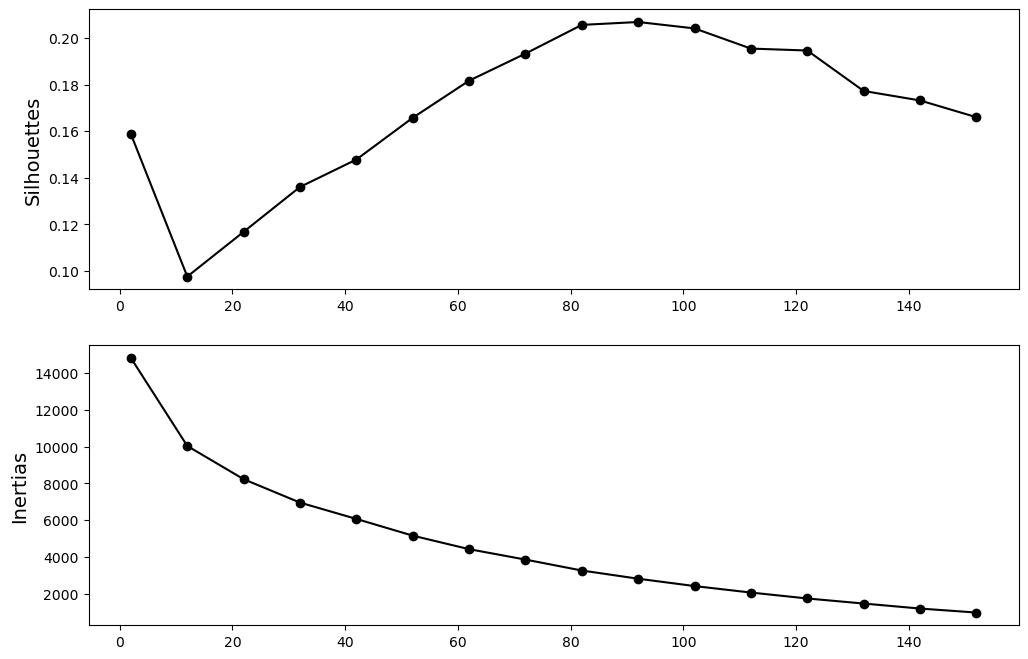

In [11]:
# plot the results
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=14, titlesize=14)

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(silhouettes[:, 0], silhouettes[:, 1], "ko-")
plt.ylabel("Silhouettes")

plt.subplot(212)
plt.plot(inertias[:, 0], inertias[:, 1], "ko-")
plt.ylabel("Inertias")

plt.show();

In [12]:
# the inertias are not useful as the plot doesn't show a significant elbow
# from the silhouettes plot, we know that the best k is close to 90

bestIndex = silhouettes[:, 1].argmax()
silhouettes[bestIndex]

array([92.        ,  0.20689197])

In [13]:
# we can run the previous code again but now just focusing on k: 80 < k < 100
# train for a different amount of clusters 
modelsByK = []
ks = list(range(80, 100, 2))

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(Xtrain)
    modelsByK.append((k, model))

silhouettes = np.array([[k, silhouette_score(X=Xtrain, labels=model.labels_)]
                        for k, model in modelsByK])

bestIndex = silhouettes[:, 1].argmax()
silhouettes[bestIndex]

array([96.        ,  0.20985295])

In [14]:
# use k = 96 for the kmeans
kmeans = modelsByK[bestIndex][1]

In [15]:
# the biggest cluster has 6 images
labels = kmeans.labels_
imgsPerCluster = {i: len(labels[labels == i]) 
                  for i in range(labels.max() + 1)}
max(imgsPerCluster.values())

6

In [16]:
def plotFacesInCluster(clusterIdx):
    facesInCluster = Xtrain[kmeans.labels_ == clusterIdx]
    facesInCluster = facesInCluster.reshape(-1, 64, 64) # 64x64 images
    nfaces = facesInCluster.shape[0]
    plt.figure(figsize=(nfaces * 2, 1.5))
    for imageId in range(nfaces):
        plt.subplot(1, nfaces, imageId + 1)
        plt.imshow(facesInCluster[imageId], cmap="binary_r")
        plt.axis("off")
    plt.show()

Faces in cluster: 6


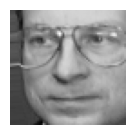

Faces in cluster: 2


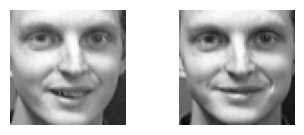

Faces in cluster: 3


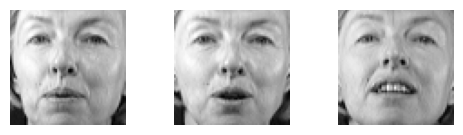

Faces in cluster: 5


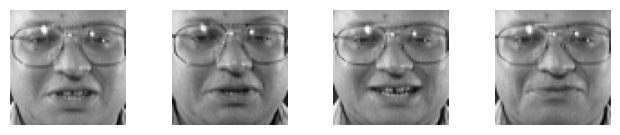

Faces in cluster: 16


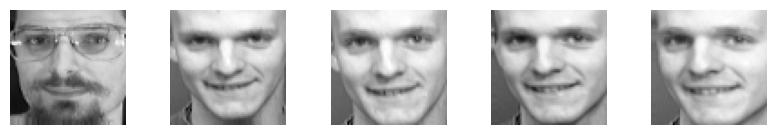

Faces in cluster: 14


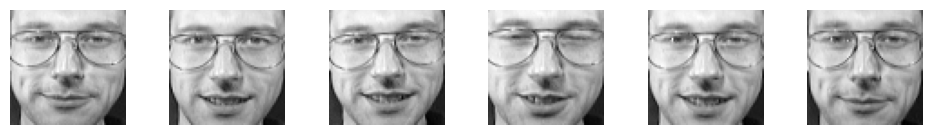

In [17]:
clustersToPlot = [6, 2, 3, 5, 16, 14]
for cluster in clustersToPlot:
    print(f"Faces in cluster: {cluster}")
    plotFacesInCluster(cluster)

In [18]:
# even though it was an unsupervised model, the model seems to group the same person inside each cluster most of the time

In [19]:
# try a classification model (RF) to predic each label
# first with the original data
from sklearn.ensemble import RandomForestClassifier # dependency

bestScore = -1
for nTrees in list(range(10, 160, 10)):
    rfc = RandomForestClassifier(n_estimators=nTrees, random_state=42)
    rfc.fit(Xtrain, ytrain)
    currScore = rfc.score(Xval, yval)
    if currScore > bestScore:
        bestScore = currScore
        bestModel = rfc
        print(f"New best model: n_estimators = {nTrees}")

New best model: n_estimators = 10
New best model: n_estimators = 20
New best model: n_estimators = 30
New best model: n_estimators = 50
New best model: n_estimators = 60


In [20]:
print(f"The best score of the Random Forest on the original data is {bestScore:.4f}")

The best score of the Random Forest on the original data is 0.8854


In [21]:
# Now try using the kmeans as a dimensionality reduction method
from sklearn.pipeline import Pipeline # dependency
modelKmeans = Pipeline([
        ("clustering", KMeans(n_init=5, random_state=42)), # kmeans.transform returns distance to every cluster
        ("random_forest", RandomForestClassifier()) # 100 trees by default
])

In [22]:
# could use gridSearch but just want to change the amount of clusters
ks = list(range(80, 100, 2))
for k in ks:
    modelKmeans.set_params(clustering__n_clusters=k)
    modelKmeans.fit(Xtrain, ytrain)
    print(f"Score for {k} clusters: {modelKmeans.score(Xval, yval):.2f}")

Score for 80 clusters: 0.76
Score for 82 clusters: 0.74
Score for 84 clusters: 0.81
Score for 86 clusters: 0.75
Score for 88 clusters: 0.74
Score for 90 clusters: 0.76
Score for 92 clusters: 0.76
Score for 94 clusters: 0.75
Score for 96 clusters: 0.77
Score for 98 clusters: 0.77


In [23]:
# the performance is less than the one of the model trained on the original data
# try using theses cluster features as New features instead of replacing the original ones
from sklearn.base import BaseEstimator, TransformerMixin

class addClusterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=96, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        
    def fit(self, X, y=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, 
                              random_state=self.random_state)
        self.kmeans_.fit(X)
        return self
        
    def transform(self, X):
        return np.c_[X, self.kmeans_.transform(X)]

In [24]:
# check if the transformer works well
transform = addClusterFeatures()
transform.fit(Xtrain)
np.all(Xtrain == transform.transform(Xtrain)[:, :4096])

True

In [25]:
newPipeline = Pipeline([
    ("transformer", addClusterFeatures(random_state=42)),
    ("random_forest", RandomForestClassifier(random_state=42)) # default 100 trees
])

In [26]:
for k in ks:
    newPipeline.set_params(transformer__n_clusters=k)
    newPipeline.fit(Xtrain, ytrain)
    print(f"Score for {k} clusters: {newPipeline.score(Xval, yval):.4f}")

Score for 80 clusters: 0.8646
Score for 82 clusters: 0.8750
Score for 84 clusters: 0.8750
Score for 86 clusters: 0.8750
Score for 88 clusters: 0.8646
Score for 90 clusters: 0.8542
Score for 92 clusters: 0.8750
Score for 94 clusters: 0.8854
Score for 96 clusters: 0.8750
Score for 98 clusters: 0.8542


In [27]:
# the extra work didn't help the performance

In [28]:
# try a gaussian mixture model to generate new faces and play a bit 
# and try to find outliers

In [29]:
# use PCA to speed training a bit
from sklearn.decomposition import PCA # dependency
from sklearn.mixture import GaussianMixture # dependency

gm = Pipeline([
    ("pca", PCA(n_components=0.99)),
    ("gm", GaussianMixture(n_components=40, random_state=42)) # 40 labels
])

In [30]:
gm.fit(Xtrain)

Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('gm', GaussianMixture(n_components=40, random_state=42))])

In [33]:
yPred = gm.predict(Xtrain)

In [47]:
gmModel = gm.steps[1][1]
pcaModel = gm.steps[0][1]
facesReduced, y = gmModel.sample(n_samples=20)
facesOriginal = pcaModel.inverse_transform(facesReduced)

In [58]:
def plotFaces(faces, nrow, ncol): # tweak the previous function to plot an array of faces
    faces = faces.reshape(-1, 64, 64) # 64x64 images
    nfaces = faces.shape[0]
    plt.figure(figsize=(2*ncol, 2*(nfaces // ncol)))
    for imageId in range(nfaces):
        plt.subplot(nrow, ncol, imageId + 1)
        plt.imshow(faces[imageId], cmap="binary_r")
        plt.axis("off")
    plt.show()

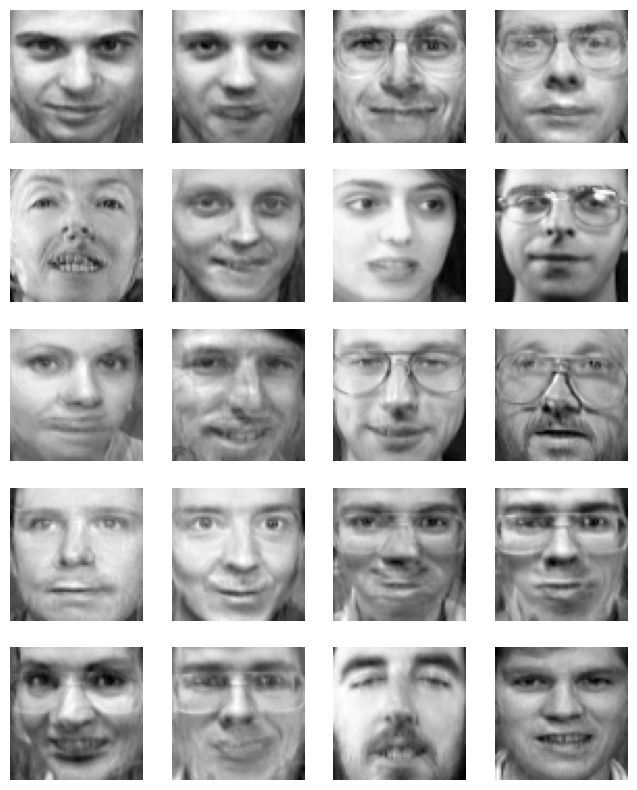

In [59]:
plotFaces(facesOriginal, 5, 4)

In [55]:
# after applying "common" transformations, the model thinks that the images
# come from another distribution (the gm assigns them low prob)

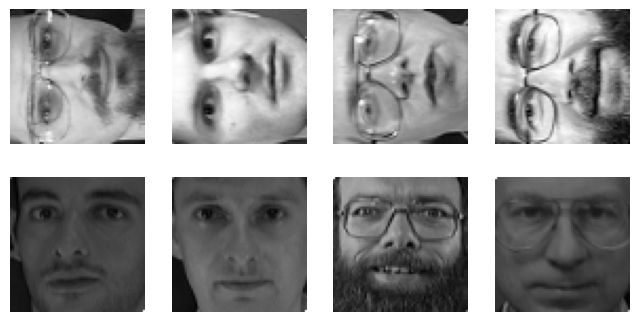

In [61]:
# to rotate, just transpose each image
nRotated = 4
rotated = np.transpose(Xtrain[:nRotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)

# to darken, just scale down the values of the pixels
nDarkened = 4
darkened = Xtrain[nRotated:nRotated + nDarkened].copy()
darkened[:, 1:-1] *= 0.3

Xmodify = np.r_[rotated, darkened]

plotFaces(Xmodify, 2, 4)

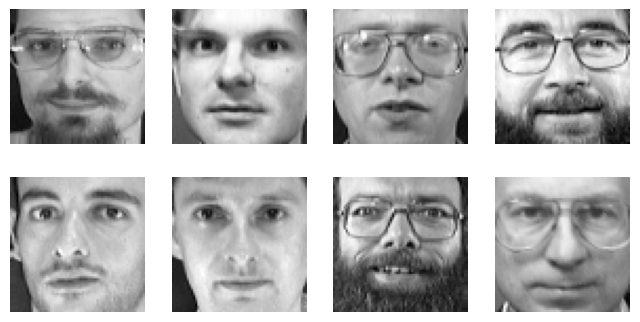

In [78]:
plotFaces(Xtrain[:nRotated + nDarkened], 2, 4)

In [70]:
# the scores for the generated imgs are VERY low compared to the ones of
# the original images

In [67]:
gm.score_samples(Xmodify[:nRotated + nDarkened]).round(2)

array([-49666595.48, -41038088.82, -41800973.68, -28267253.4 ,
       -55489679.75, -66281117.93, -72779012.  , -66652247.69])

In [80]:
gm.score_samples(Xtrain[:nRotated + nDarkened]).round(2)

array([912.01, 948.66, 955.83, 956.73, 939.14, 947.  , 987.  , 889.19])

In [81]:
# one way to detect outliers is to compute the reconstruction error of the pca

In [86]:
def reconstructionError(pca, X):
    transformed = pca.transform(X)
    reconstructed = pca.inverse_transform(transformed)
    error = np.mean(np.square(X - reconstructed)) # RMSE
    return error

In [90]:
modError = reconstructionError(pcaModel, Xmodify[:nRotated + nDarkened])
oriError = reconstructionError(pcaModel, Xtrain[:nRotated + nDarkened])
print("Errors")
print(f"Modified X: {modError:.6f}")
print(f"Original X: {oriError:.6f}")

Errors
Modified X: 0.005408
Original X: 0.000099


In [95]:
# modified images get 5388.3% bigger error
(modError - oriError) / oriError

53.88294

In [96]:
oriError * 53.9

0.005311369345872663

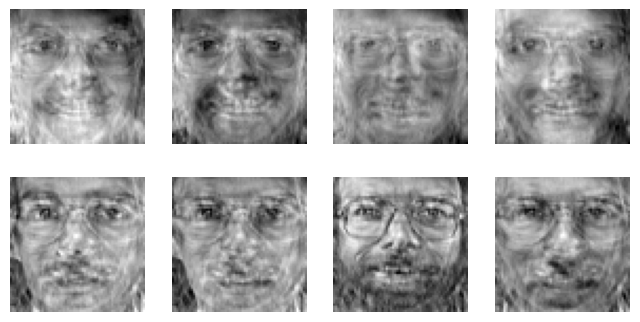

In [99]:
# this is because the pca.inverse_transform tries to get normal faces
# i.e. without modifications
reconFacesModify = pcaModel.inverse_transform(
    pcaModel.transform(Xmodify[:nRotated + nDarkened])
)
plotFaces(reconFacesModify, 2, 4)

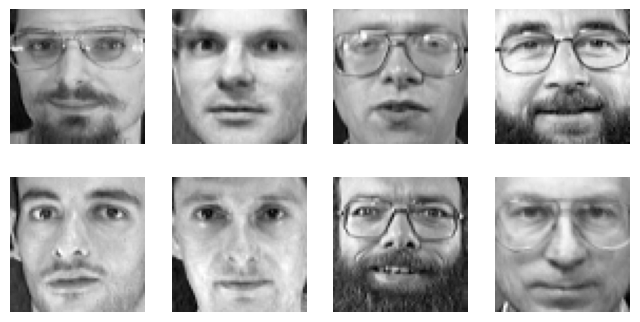

In [100]:
# while with the original images, it works fine
reconFacesModify = pcaModel.inverse_transform(
    pcaModel.transform(Xtrain[:nRotated + nDarkened])
)
plotFaces(reconFacesModify, 2, 4)

In [101]:
# too much unsupervised learning for today!